# 2-Cell and 3-Cell Motifs in PyC Subgraph (Full)

In [1]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.graph_creation import *
from utils.motif_counts import *
from utils.visualization import *

## Create PyC Subgraph

In [3]:
pyc_synapses = pd.read_csv('data/synapses.csv')
pyc_synapses

,pre,post
0,648518346349539437,648518346349531254
1,648518346349537978,648518346349537300
2,648518346349533058,648518346349538715
3,648518346349539333,648518346349539806
4,648518346349523975,648518346349537716
...,...,...
1976,648518346349539110,648518346349538440
1977,648518346349539110,648518346349523993
1978,648518346349539110,648518346349524141
1979,648518346349539110,648518346349539900


In [4]:
pyc_soma = pd.read_csv('data/soma.csv')
pyc_soma

,segmentation,segment_id,manual_id,loc,axon_len,dendrite_len
0,185,648518346349491311,466,[314028 159940 77280],0.000000,1441.069000
1,185,648518346349492130,499,[291484 145484 80960],0.000000,747.483938
2,185,648518346349492197,503,[270948 158088 86240],0.000000,586.186063
3,185,648518346349492682,163,[461372 212624 27640],643.547438,979.816375
4,185,648518346349493472,549,[431864 156576 85720],0.000000,0.000000
...,...,...,...,...,...,...
358,185,648518346349540048,80,[349132 163492 11480],961.385250,1321.124250
359,185,648518346349540051,259,[444892 247424 47480],61.243563,1999.626500
360,185,648518346349540053,102,[446104 253936 18320],56.518617,1612.330500
361,185,648518346349540055,139,[340468 248332 23400],46.961094,3101.869750


In [5]:
# create the simple directed graph (no self-loops, no multi-edges)
# treat multiple synapses as one connection
pyc_subgraph = synapses_to_connections(pyc_synapses[['pre','post']])
# remove self-loops
g_actual = remove_autapses(edges_to_graph(pyc_subgraph))
g_actual.add_nodes_from(pyc_soma["segment_id"])

In [6]:
print(nx.info(g_actual))

Name: 
Type: DiGraph
Number of nodes: 363
Number of edges: 1750
Average in degree:   4.8209
Average out degree:   4.8209


In [7]:
axls = {n:np.array(pyc_soma[pyc_soma["segment_id"] == n]["axon_len"])[0] for n in g_actual.nodes()}

In [8]:
g_full = get_thresholded_graph(g_actual, axls, -1)
print(nx.info(g_full))

Name: 
Type: DiGraph
Number of nodes: 363
Number of edges: 1750
Average in degree:   4.8209
Average out degree:   4.8209


## 2-Cell Motifs

In [9]:
%%time
# count 2-cell motifs in the observation
obs_two_counts = count_two_neuron_motifs_graph(g_full)
# analytically compute 2-cell motif counts in Erdos-Renyi model
er_two_counts = compute_ER_two_neuron_motifs(g_full)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.29 ms


In [10]:
%%time
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_two_counts = sample_motifs_parallel_continuous(continuous_sample_two_neuron_motifs, g_full, samples=s, niters=int(1e4), threads=10)

CPU times: user 112 ms, sys: 48 ms, total: 160 ms
Wall time: 2min 6s


connect probability =  0.01331750452795154


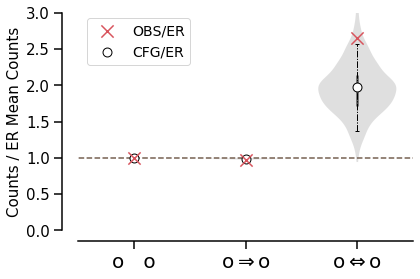

In [41]:
# relative counts in ratio (/ER expected counts)
res_two = plot_two_neuron_counts_violin(obs_two_counts, er_two_counts, config_two_counts, ylim=(0, 3), fname="full/full_2_violin");

In [12]:
res_two

,obs,er_exp,config_exp,config_std,config_z
actual_edges,NaN,NaN,1750.000,0.000000,NaN
autapses,NaN,NaN,0.000,0.000000,NaN
bi,31.0,11.652816,22.864,4.255304,1.911967
neurons,NaN,NaN,363.000,0.000000,NaN
null,63984.0,63964.652816,63975.864,4.255304,1.911967
potential_edges,NaN,NaN,131406.000,0.000000,NaN
uni,1688.0,1726.694367,1704.272,8.510608,-1.911967


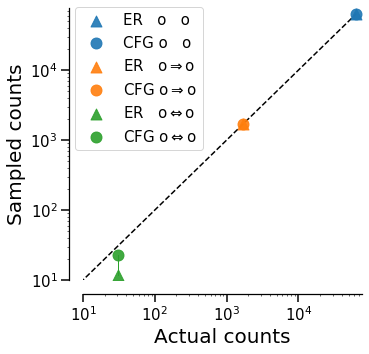

In [13]:
plot_two_neuron_counts_scatter(obs_two_counts, er_two_counts, config_two_counts, figsize=(5,5), fname="full/full_2_scatter")

In [14]:
# p-values
np.minimum((config_two_counts > obs_two_counts).sum(0) / 1000, 
           (config_two_counts < obs_two_counts).sum(0) / 1000)

neurons            0.000
autapses           0.000
actual_edges       0.000
uni                0.029
bi                 0.029
potential_edges    0.000
null               0.029
dtype: float64

## 3-Cell Motifs

In [15]:
%%time
# count 3-cell motifs in the observation
obs_three_counts, _ = count_three_neuron_motifs(*graph_to_sets(g_full), motifs)
# analytically compute 2-cell motif counts in Erdos-Renyi model
three_pr, two_pr = compute_three_neuron_motif_probabilities(g_full)
er_three_counts = compute_expected_three_neuron_motifs(g_full, three_pr)

CPU times: user 3min 59s, sys: 172 ms, total: 3min 59s
Wall time: 4min


In [16]:
%%time
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_three_counts = sample_motifs_parallel_continuous(continuous_sample_three_neuron_motifs, g_full, samples=s, niters=int(1e4), threads=10)

CPU times: user 1.26 s, sys: 152 ms, total: 1.42 s
Wall time: 10h 5min 45s


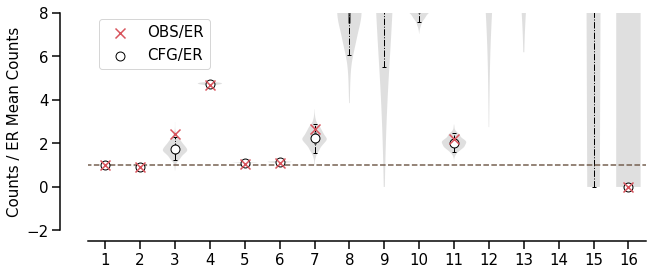

In [17]:
# relative counts in ratio (/ER expected counts)
res_three = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts, config_three_counts, 
                                            subtitle='', ylim=[-2, 8], fname="full/full_3_violin", figsize=(10,4))

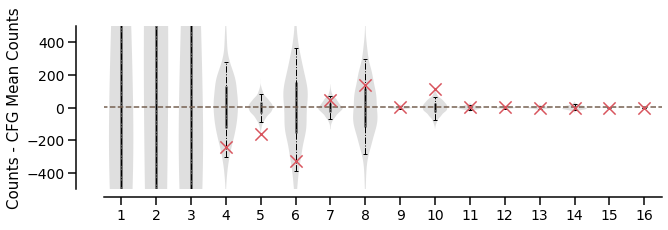

In [18]:
# relative counts in difference (-CFG expected counts)
plot_three_neuron_counts_diff_violin(obs_three_counts, er_three_counts, config_three_counts, 
                                     subtitle='', ylim=[-500, 500], fname="full/full_3_violin_diff");

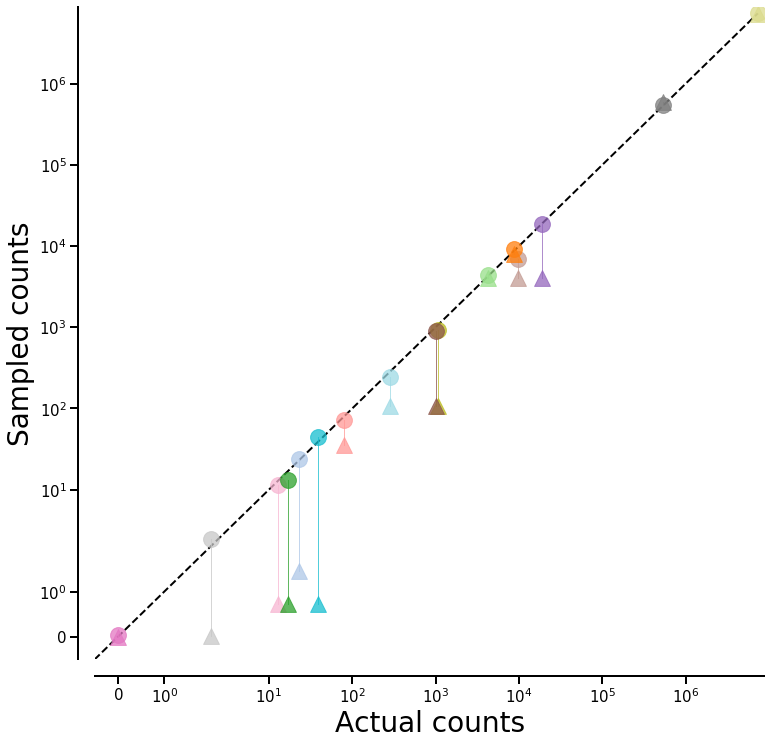

In [19]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts, config_three_counts, figsize=(12,12), fname="full/full_3_scatter")

In [20]:
res_three

,obs,er_exp,config_exp,config_std,config_z
1,7321192,7.295175e+06,7318558.788,1289.358451,2.042265
2,541017,5.907890e+05,545983.579,2374.228136,-2.091871
3,9724,3.987014e+03,6959.912,1300.608313,2.125227
4,18707,3.987014e+03,18950.896,184.505831,-1.321888
5,4267,3.987014e+03,4428.467,50.731298,-3.182789
6,8821,7.974029e+03,9148.199,231.254232,-1.414889
7,287,1.076275e+02,241.205,43.525572,1.052140
8,1071,1.076275e+02,933.465,179.673352,0.765472
9,13,7.263378e-01,11.579,5.407310,0.262792
10,1002,1.076275e+02,888.235,42.060371,2.704803


In [21]:
# p-values
np.minimum((config_three_counts > obs_three_counts).sum(0) / 1000, 
           (config_three_counts < obs_three_counts).sum(0) / 1000)

1     0.024
2     0.022
3     0.020
4     0.093
5     0.001
6     0.080
7     0.151
8     0.222
9     0.315
10    0.003
11    0.242
12    0.155
13    0.426
14    0.349
15    0.352
16    0.000
dtype: float64

## 3-Cell Motifs (Generalized ER and CFG)

In [22]:
%%time
# analytically compute 2-cell motif counts in Erdos-Renyi model
three_pr_GE, two_pr_GE = compute_three_neuron_motif_probabilities_GE(g_full)
er_three_counts_GE = compute_expected_three_neuron_motifs(g_full, three_pr_GE)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.13 ms


In [23]:
%%time
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_three_counts_GE = sample_motifs_parallel_continuous(continuous_sample_three_neuron_motifs_GE, g_full, samples=s, niters=int(1e4), threads=10)

CPU times: user 888 ms, sys: 104 ms, total: 992 ms
Wall time: 6h 52min 22s


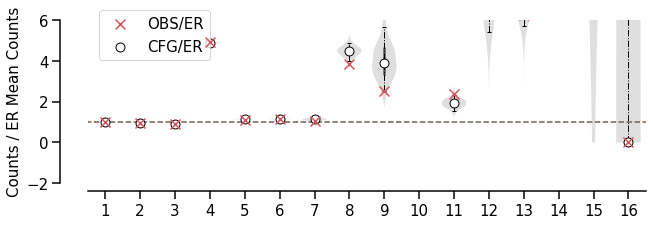

In [24]:
# relative counts in ratio (/ER expected counts)
res_three_GE = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts_GE, config_three_counts_GE, 
                                            subtitle='', ylim=[-2, 6], fname="full/full_3_violin_GE", figsize=(10,3))

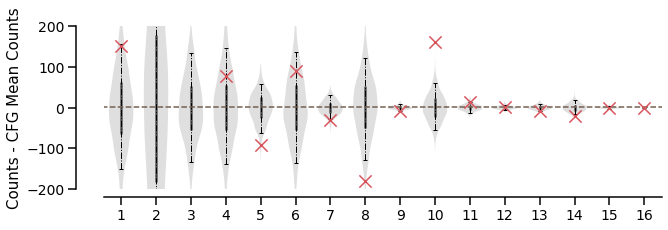

In [25]:
# relative counts in difference (-CFG expected counts)
plot_three_neuron_counts_diff_violin(obs_three_counts, er_three_counts_GE, config_three_counts_GE, 
                                     subtitle='', ylim=[-200, 200], fname="full/full_3_violin_diff_GE");

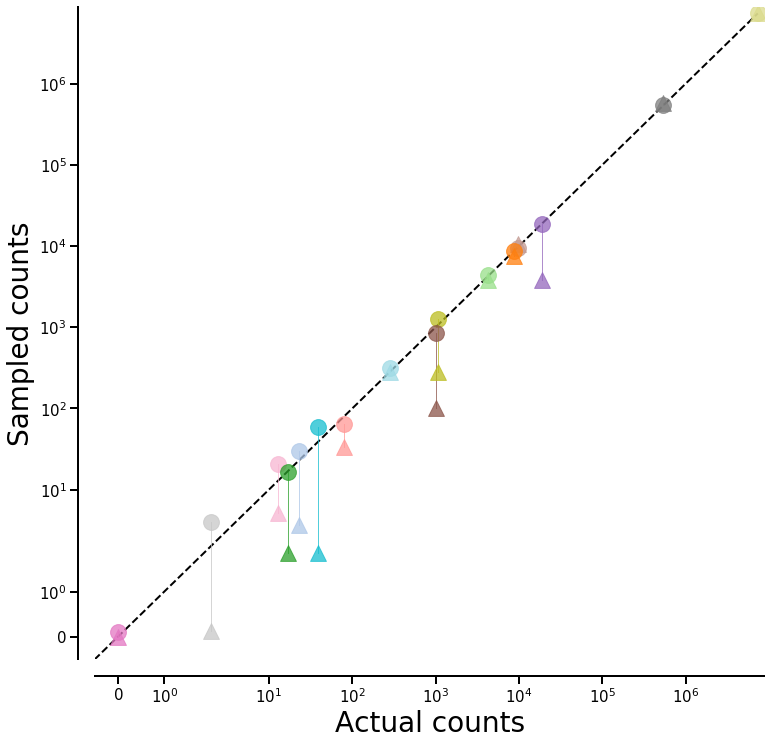

In [26]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts_GE, config_three_counts_GE, 
                                 figsize=(12,12), fname="full/full_3_scatter_GE")

In [27]:
res_three_GE

,obs,er_exp,config_exp,config_std,config_z
1,7321192,7.301796e+06,7321040.701,93.113220,1.624893
2,541017,5.778991e+05,541429.486,266.772955,-1.546206
3,9724,1.061308e+04,9467.095,81.081960,3.168461
4,18707,3.811475e+03,18630.354,86.233641,0.888818
5,4267,3.811475e+03,4359.020,37.930704,-2.426003
6,8821,7.622950e+03,8730.522,82.481214,1.096953
7,287,2.799899e+02,317.969,18.190132,-1.702516
8,1071,2.799899e+02,1250.179,76.166044,-2.352479
9,13,5.141994e+00,20.691,4.723328,-1.628301
10,1002,1.005528e+02,840.240,34.605374,4.674418


In [28]:
# p-values
np.minimum((config_three_counts_GE > obs_three_counts).sum(0) / 1000, 
           (config_three_counts_GE < obs_three_counts).sum(0) / 1000)

1     0.056
2     0.065
3     0.000
4     0.191
5     0.010
6     0.132
7     0.036
8     0.012
9     0.024
10    0.000
11    0.040
12    0.403
13    0.089
14    0.017
15    0.090
16    0.000
dtype: float64

## Clustering Coefficient

In [29]:
# clustering coefficient of the observed network
nx.transitivity(g_full.to_undirected())

0.09511077158135982

In [30]:
# expected clustering coefficient of the networsk sampled from the ER model
1-two_pr['pr_null']

0.02645765312905113

In [31]:
# expected clustering coefficient of the networsk sampled from the CFG model
clustering_coef(config_three_counts).mean()

0.08506556589160726

In [32]:
# expected clustering coefficient of the networsk sampled from the generalized ER model
1-two_pr_GE['pr_null']

0.02616318889548419

In [33]:
# expected clustering coefficient of the networsk sampled from the generalized CFG model
clustering_coef(config_three_counts_GE).mean()

0.083758307853394

## CFG v.s. Generalized ER

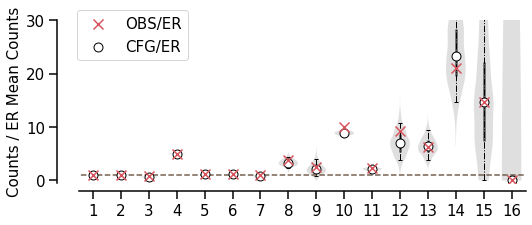

In [38]:
# relative counts in ratio (/ER expected counts)
res_three_CGE = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts_GE, config_three_counts, 
                                            subtitle='', ylim=[-0.5, 30], fname="full/full_3_violin_CGE", figsize=(8,3))

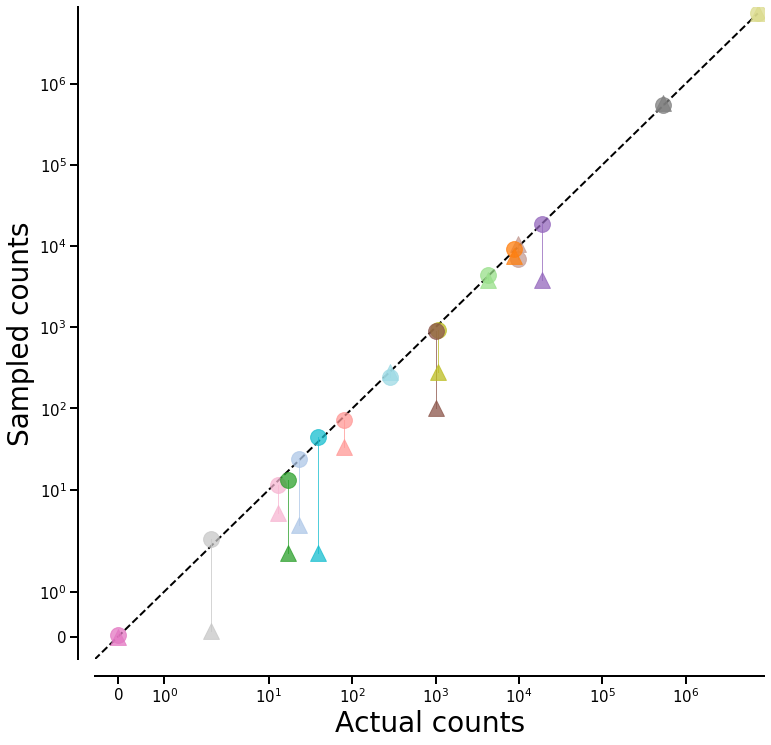

In [39]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts_GE, config_three_counts, 
                                 figsize=(12,12), fname="full/full_3_scatter_CGE")